# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification. 

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case.

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical. 
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (cbow)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


## Preparing the data

Let's first download the data set and take a look.

In [ ]:
import re
import random
import time
import math
import os
import numpy as np
import pandas as pd
import nltk
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
from collections import Counter, OrderedDict, defaultdict, namedtuple
import matplotlib.pyplot as plt
plt.style.use('default')
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101
from torch import nn, optim

Using torch 1.13.0+cu116


In [ ]:
# Set global variables
HOME = './'
DATA_DIR = HOME + 'data'
MODEL_DIR = HOME + 'models'
OUTPUT_DIR = HOME + 'outputs'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR) 

In [ ]:
# Download data
# !wget -P ./data/ -nc http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
# !unzip -n ./data/trainDevTestTrees_PTB.zip

In [ ]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path): 
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [ ]:
# s = next(filereader("trees/dev.txt"))
# print(s)

In [ ]:
# We can use NLTK to better visualise the tree structure of the sentence
# tree = Tree.fromstring(s)
# print(TreePrettyPrinter(tree))

The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [ ]:
# Let's first make a function that extracts the tokens (the leaves).
def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [ ]:
# shift-reduce for trees
SHIFT = 0
REDUCE = 1
def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [ ]:
# Now let's first see how large our data sets are.
for path in (f'{DATA_DIR}/trees/train.txt', f'{DATA_DIR}/trees/dev.txt', f'{DATA_DIR}/trees/test.txt'):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

./data/trees/train.txt 8544
./data/trees/dev.txt 1101
./data/trees/test.txt 2210


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and 
the transitions (explained later).

In [ ]:
# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])

# Function to get subtrees from a tree
def get_subtrees(tree, min_height = 0):
  subtrees = [tree]
  tree_positions = tree.treepositions()[1:]
  for positions in tree_positions:    
    subtree = tree[positions]
    if type(subtree) is not str:
      if(subtree.height() >= min_height and len(subtree.leaves()) >= 2):
        subtrees.append(subtree)
  
  return subtrees

def examplereader(path, lower=False, subtrees=False, min_height=0):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    if subtrees:
        for subtree in get_subtrees(Tree.fromstring(line), min_height = min_height):
            subtree_string = re.sub('\s+',' ',str(subtree))
            tokens = tokens_from_treestring(line)
            tree = subtree
            label = int(subtree_string[1])
            trans = transitions_from_treestring(subtree_string)
            yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)
    else:
        tokens = tokens_from_treestring(line)
        tree = Tree.fromstring(line)  # use NLTK's Tree
        label = int(line[1])
        trans = transitions_from_treestring(line)
        yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)
  

# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader(f'{DATA_DIR}/trees/train.txt', lower=LOWER))
dev_data = list(examplereader(f'{DATA_DIR}/trees/dev.txt', lower=LOWER))
test_data = list(examplereader(f'{DATA_DIR}/trees/test.txt', lower=LOWER))
# Using subtrees
train_data_st = list(examplereader(f'{DATA_DIR}/trees/train.txt', lower=LOWER, subtrees=True, min_height=2))
dev_data_st = list(examplereader(f'{DATA_DIR}/trees/dev.txt', lower=LOWER, subtrees=True, min_height=2))
test_data_st = list(examplereader(f'{DATA_DIR}/trees/test.txt', lower=LOWER, subtrees=True, min_height=2))


print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))
print("train subtrees", len(train_data_st))
print("dev subtrees", len(dev_data_st))
print("test subtrees", len(test_data_st))

train 8544
dev 1101
test 2210
train subtrees 155022
dev subtrees 20173
test subtrees 40195


#### Make separate datasets for short and long sentences

In [ ]:
# Get avg length of sentences in dataset
def get_avg_sentence_length(path, lower=False):
    """Returns the average sentence length in the dataset."""
    sentence_lengths = []
    for line in filereader(path):
        line = line.lower() if lower else line
        tokens = tokens_from_treestring(line)
        sentence_length = len(tokens)
        sentence_lengths.append(sentence_length)
    return sum(sentence_lengths) / len(sentence_lengths)

avg_sentence_length = get_avg_sentence_length(f'{DATA_DIR}/trees/test.txt', lower=LOWER)
print(f'Average sentence length in test set: {avg_sentence_length:.2f}')

Average sentence length in test set: 19.19


The avg sentence length is approximately 19 words long. We will use this as our threshold to split the data into two datasets: one for short sentences and one for long sentences.

In [ ]:
# Create separate train, dev and test sets for short and long sentences
LENGTH_THRESHOLD = 19
test_data_short = [example for example in test_data if len(example.tokens) < LENGTH_THRESHOLD]
test_data_long = [example for example in test_data if len(example.tokens) >= LENGTH_THRESHOLD]
print(f'The test set has {len(test_data_short)} short sentences and {len(test_data_long)} long sentences.')

The test set has 1106 short sentences and 1104 long sentences.


#### Vocabulary 
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [ ]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).
class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)

class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""
  
  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1
    
  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)    
    
  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included  
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)   
    
    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [ ]:
# This process should be deterministic and should have the same result 
# if run multiple times on the same data set.
v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


#### Sentiment label vocabulary

In [ ]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
# And let's also create the opposite mapping.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})

## PyTorch

In Colab notebooks, the last available version of PyTorch is already installed.The current stable version is 1.7.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)
# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
# Helper function to set seed in all libraries
# But, the outputs are still not reproducible on Colab!
RANDOM_SEED = 42
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes. 

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [ ]:
class BOW(nn.Module):
  """A simple bag-of-words model"""
  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab
    
    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)
    
    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)        

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)
    
    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [ ]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [ ]:
# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))
    
print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table. 

In [ ]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """
  
  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]
  
  x = torch.LongTensor([x])
  x = x.to(device)
  
  y = torch.LongTensor([example.label])
  y = y.to(device)
  
  return x, y

#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [ ]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:
    
    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)
    
    # get the prediction
    prediction = logits.argmax(dim=-1)
    
    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense. 

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [ ]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    # print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model. 

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent). 

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html). 

In [ ]:
def train_model(model, optimizer, num_iterations=30000, 
				print_every=1000, eval_every=300,
				batch_fn=get_examples, 
				prep_fn=prepare_example,
				eval_fn=simple_evaluate,
				batch_size=1, eval_batch_size=None, 
				model_dir=MODEL_DIR,
				rand_seed=RANDOM_SEED,
				subtrees=False, patience=5000, suffix='',
				verbose=True):
	"""Train a model."""  
	# Load data
	train_d = train_data_st if subtrees else train_data
	dev_d = dev_data
	test_d = test_data
	
	# intialize variables
	iter_i = 0
	train_loss = 0.
	print_num = 0
	start = time.time()
	criterion = nn.CrossEntropyLoss() # loss function
	best_eval = 0.
	best_iter = 0
	# store train loss and validation accuracy during training
	# so we can plot them afterwards
	train_losses = []
	val_accs = []  
	if eval_batch_size is None:
		eval_batch_size = batch_size
	#train
	set_seed(rand_seed)   # set seed for reproducibility
	model.to(device)      # move the model parameters to CPU/GPU
	while True:  # when we run out of examples, shuffle and continue
		for batch in batch_fn(train_d, batch_size=batch_size):
			# forward pass
			model.train()
			x, targets = prep_fn(batch, model.vocab)
			logits = model(x)
			B = targets.size(0)  # later we will use B examples per update
			# compute cross-entropy loss (our criterion)
			# note that the cross entropy loss function computes the softmax for us
			optimizer.zero_grad()      
			loss = criterion(logits.view([B, -1]), targets.view(-1))
			train_loss += loss.item()
			loss.backward()
			optimizer.step()
			print_num += 1
			iter_i += 1
			# print info
			if iter_i % print_every == 0:
				train_losses.append(train_loss)
				train_loss = 0.
				if verbose:
					print("Iter %r: loss=%.4f, time=%.2fs" % 
							(iter_i, train_loss, time.time()-start))
					print_num = 0        

			# evaluate
			if iter_i % eval_every == 0:
				_, _, accuracy = eval_fn(model, dev_d, batch_size=eval_batch_size, batch_fn=batch_fn, prep_fn=prep_fn)
				val_accs.append(accuracy)
				if verbose:
					print("iter %r: dev acc=%.4f" % (iter_i, accuracy))       
				
				# save best model parameters
				if accuracy > best_eval:
					# print("new highscore")
					best_eval = accuracy
					best_iter = iter_i
					lr = optimizer.param_groups[0]["lr"]
					ckpt = {
							"state_dict": model.state_dict(),
							"optimizer_state_dict": optimizer.state_dict(),
							"train_losses": train_losses,
							"val_accs": val_accs,
							"best_eval": best_eval,
							"best_iter": best_iter
						}
					path = f'{model_dir}/{model.__class__.__name__}{suffix}_st={subtrees}_lr={lr}_bs={batch_size}_iter={num_iterations}.pt'     
					torch.save(ckpt, path)
				
			# done training
			if iter_i == num_iterations or iter_i - best_iter > patience:
				print("Done training")
				if iter_i < num_iterations:
					print("Early stopping")
				# evaluate on train, dev, and test with best model
				# print("Loading best model")
				path = f'{model_dir}/{model.__class__.__name__}{suffix}_st={subtrees}_lr={lr}_bs={batch_size}_iter={num_iterations}.pt'     
				ckpt = torch.load(path)
				model.load_state_dict(ckpt["state_dict"])
			
				_, _, train_acc = eval_fn(
					model, train_d, batch_size=eval_batch_size, 
					batch_fn=batch_fn, prep_fn=prep_fn)
				_, _, dev_acc = eval_fn(
					model, dev_d, batch_size=eval_batch_size,
					batch_fn=batch_fn, prep_fn=prep_fn)
				_, _, test_acc = eval_fn(
					model, test_d, batch_size=eval_batch_size, 
					batch_fn=batch_fn, prep_fn=prep_fn)
				_, _, test_acc_short = eval_fn(model, test_data_short, batch_size=eval_batch_size, batch_fn=batch_fn, prep_fn=prep_fn)
				_, _, test_acc_long = eval_fn(model, test_data_long, batch_size=eval_batch_size, batch_fn=batch_fn, prep_fn=prep_fn)
			
				print("best model iter {:d}: "
						"train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
								best_iter, train_acc, dev_acc, test_acc))
				
				return train_losses, val_accs, test_acc, test_acc_short, test_acc_long

def train_loop(model_generator, optimizer_generator,
			   num_iterations=30000, 
			   print_every=1000, eval_every=300,
			   batch_fn=get_examples, 
			   prep_fn=prepare_example,
			   eval_fn=simple_evaluate,
			   batch_size=1, eval_batch_size=None,
			   patience=5000, model_dir=MODEL_DIR,
			   num_seeds=3, subtrees=False, suffix='',
			   verbose=True):
	"""Train a model with multiple seeds."""

	test_accs, test_accs_short, test_accs_long = [], [], []
	for seed in range(num_seeds):
		print(f'Training model with seed {seed}')
		set_seed(seed)
		model = model_generator()
		model.to(device)
		optimizer = optimizer_generator(model)

		# train model
		train_losses, val_accs, test_acc, test_acc_short, test_acc_long = train_model(model, optimizer, num_iterations=num_iterations,
					print_every=print_every, eval_every=eval_every, batch_fn=batch_fn, prep_fn=prep_fn, eval_fn=eval_fn,
					batch_size=batch_size, eval_batch_size=eval_batch_size, patience=patience, model_dir=model_dir, rand_seed=seed, subtrees=subtrees, suffix=suffix, verbose=verbose)

		test_accs.append(test_acc)
		test_accs_short.append(test_acc_short)
		test_accs_long.append(test_acc_long)
		print(f'Test accuracy for seed {seed}: {test_acc*100:.2f}%')
	
	return model, train_losses, val_accs, test_accs, test_accs_short, test_accs_long

In [ ]:
# Helper function to run inference from a trained model
def eval_saved_model(model, ckpt_path, eval_fn, prep_fn=prepare_example, test_d=test_data, model_dir=MODEL_DIR, batch_size=1, batch_fn=get_examples):
  # evaluate on train, dev, and test with best model
  if not os.path.exists(ckpt_path):
    raise ValueError(f'Checkpoint path {ckpt_path} does not exist')
  ckpt = torch.load(ckpt_path)
  model.to(device)
  model.load_state_dict(ckpt["state_dict"])

  _, _, test_acc = eval_fn(
      model, test_d, batch_size=batch_size, 
      batch_fn=batch_fn, prep_fn=prep_fn)
  print(f'Test accuracy: {test_acc:.4f}')
  
  return test_acc

# Helpler function to plot the training loss and validation accuracy
def plot_loss_acc(losses, accuracies, model_name, output_dir=OUTPUT_DIR, filename=None, print_every=1000, eval_every=300, save=True):
    loss_iters = [i * print_every for i in range(len(losses))]
    acc_iters = [i * eval_every for i in range(len(accuracies))]
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].plot(loss_iters, losses)
    axs[0].set_title('Training loss')
    axs[0].set_xlabel('Iterations')
    axs[1].plot(acc_iters, accuracies)
    axs[1].set_title('Validation accuracy')
    axs[1].set_xlabel('Iterations')
    fig.suptitle(f'{model_name} training results')
    fig.tight_layout()
    if save:
        path = filename if filename else f'{model_name}_loss_acc.png'
        fig.savefig(os.path.join(output_dir, path))

### Training the BOW model

Training model with seed 0
Done training
Early stopping
best model iter 34800: train acc=0.3303, dev acc=0.2579, test acc=0.2434
Test accuracy for seed 0: 24.34%
Training model with seed 1
Done training
best model iter 49200: train acc=0.3862, dev acc=0.2725, test acc=0.2819
Test accuracy for seed 1: 28.19%
Training model with seed 2
Done training
best model iter 47400: train acc=0.3766, dev acc=0.2961, test acc=0.2995
Test accuracy for seed 2: 29.95%
Average test accuracy of BOW across 3 runs: 27.50 +- 2.34 %
Average test accuracy of BOW on short sentences across 3 runs: 26.76 +- 2.18 %
Average test accuracy of BOW on long sentences across 3 runs: 28.23 +- 2.59 %


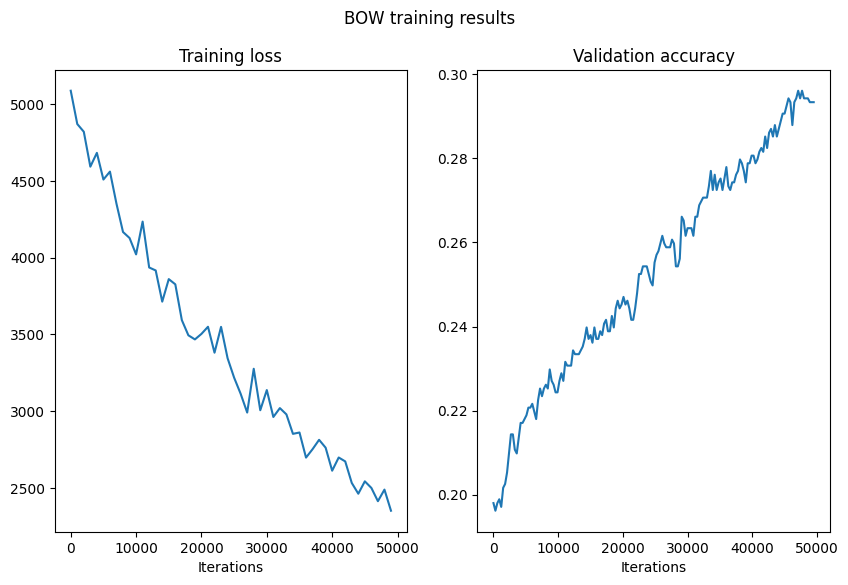

In [ ]:
# If everything is in place we can now train our first model!
# bow_model = BOW()
# print(bow_model)
# # bow_model = bow_model.to(device)
# optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)
# bow_losses, bow_accuracies = train_model(
#     bow_model, optimizer, num_iterations=30000)
# run training loop over multiple seeds
n_runs = 3
bow_model, bow_losses, bow_accuracies, bow_test_accs, bow_test_accs_short, bow_test_accs_long = train_loop(
    lambda: BOW(vocab_size=len(v.w2i), embedding_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=50000, num_seeds=n_runs, patience=10000, verbose=False)

print(f'Average test accuracy of BOW across {n_runs} runs: {np.mean(bow_test_accs)*100:.2f} +- {np.std(bow_test_accs)*100:.2f} %')
print(f'Average test accuracy of BOW on short sentences across {n_runs} runs: {np.mean(bow_test_accs_short)*100:.2f} +- {np.std(bow_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of BOW on long sentences across {n_runs} runs: {np.mean(bow_test_accs_long)*100:.2f} +- {np.std(bow_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(bow_losses, bow_accuracies, 'BOW', save=True)

In [ ]:
# Using subtrees
bow_model_st = BOW(vocab_size=len(v.w2i), embedding_dim=len(t2i), vocab=v)
optimizer = optim.Adam(bow_model_st.parameters(), lr=0.0005)
_, _, bow_test_accs_st, bow_test_accs_st_short, bow_test_accs_st_long = train_model(bow_model_st, optimizer, num_iterations=50000, patience=10000, subtrees=True, verbose=False)
print(f'Test accuracy of BOW with subtrees: {bow_test_accs_st*100:.2f} %')

Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*. 
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes. 

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [ ]:
class CBOW(nn.Module):
    """A continuous bag-of-words model"""
    def __init__(self, vocab_size, embedding_dim,output_dim, vocab):
        super().__init__()
        self.vocab = vocab
		
		# this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

		# this is a trainable bias term for the embedding
        self.embed_bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

		# this is a linear layer mapping sentence embeddings to logits
        self.linear = nn.Linear(embedding_dim, output_dim)

    def forward(self, inputs):
		# this is the forward pass of the neural network
		# it applies a function to the input and returns the output
        embeds = self.embed(inputs)
        sent_embed = embeds.sum(1) + self.embed_bias
        logits = self.linear(sent_embed)
        
        return logits

Average test accuracy of CBOW across 3 runs: 36.32 +- 1.63 %
Average test accuracy of CBOW on short sentences across 3 runs: 37.13 +- 1.03 %
Average test accuracy of CBOW on long sentences across 3 runs: 35.51 +- 2.22 %


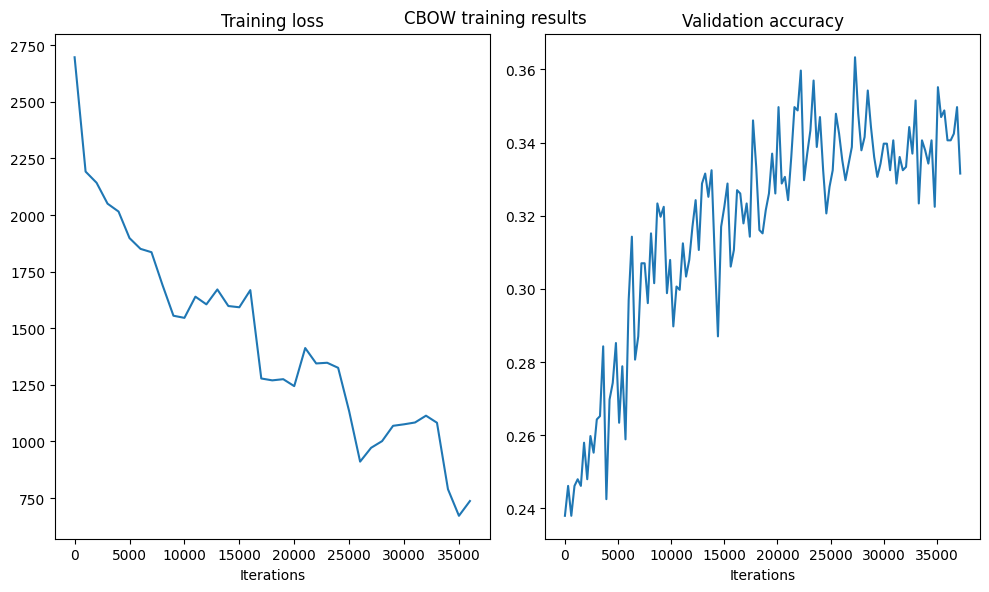

In [ ]:
# run training loop over multiple seeds
n_runs = 3
cbow_model, cbow_losses, cbow_accuracies, cbow_test_accs, cbow_test_accs_short, cbow_test_accs_long = train_loop(
    lambda: CBOW(vocab_size=len(v.w2i), embedding_dim=300,output_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=50000, num_seeds=n_runs, patience=10000, verbose=False)
print(f'Average test accuracy of CBOW across {n_runs} runs: {np.mean(cbow_test_accs)*100:.2f} +- {np.std(cbow_test_accs)*100:.2f} %')
print(f'Average test accuracy of CBOW on short sentences across {n_runs} runs: {np.mean(cbow_test_accs_short)*100:.2f} +- {np.std(cbow_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of CBOW on long sentences across {n_runs} runs: {np.mean(cbow_test_accs_long)*100:.2f} +- {np.std(cbow_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(cbow_losses, cbow_accuracies, 'CBOW', save=True)

In [ ]:
# Using subtrees
cbow_model_st = CBOW(vocab_size=len(v.w2i), embedding_dim=300,output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(cbow_model_st.parameters(), lr=0.0005)
_, _, test_acc_cbow_st, test_acc_cbow_st_short, test_acc_cbow_st_long = train_model(cbow_model_st, optimizer, num_iterations=50000, patience=10000, subtrees=True, verbose=False)
print(f'Test accuracy of CBOW model with subtrees: {test_acc_cbow_st*100:.2f}%')

Done training
Early stopping
best model iter 14400: train acc=0.4850, dev acc=0.4826, test acc=0.2018
Test accuracy of CBOW model with subtrees: 20.18%


# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function. 
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization. 

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [ ]:
class DeepCBOW(nn.Module):
	"""A continuous deep bag-of-words model"""
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
		super(DeepCBOW, self).__init__()
		self.vocab = vocab

		# this is a trainable look-up table with word embeddings
		self.embed = nn.Embedding(vocab_size, embedding_dim)

		# this is a trainable bias term for the embedding
		self.embed_bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

		self.layers = nn.Sequential(nn.Linear(embedding_dim, hidden_dim),
							  nn.Tanh(), 
							  nn.Linear(hidden_dim, hidden_dim),
							  nn.Tanh(),
							  nn.Linear(hidden_dim, output_dim))

	def forward(self, inputs):
		# this is the forward pass of the neural network
		# it applies a function to the input and returns the output

		embeds = self.embed(inputs)
		sent_embed = embeds.sum(1) + self.embed_bias
		logits = self.layers(sent_embed)

		return logits

Average test accuracy of DeepCBOW across 3 runs: 38.24 +- 1.07 %
Average test accuracy of DeepCBOW on short sentences across 3 runs: 39.12 +- 0.71 %
Average test accuracy of DeepCBOW on long sentences across 3 runs: 37.35 +- 1.68 %


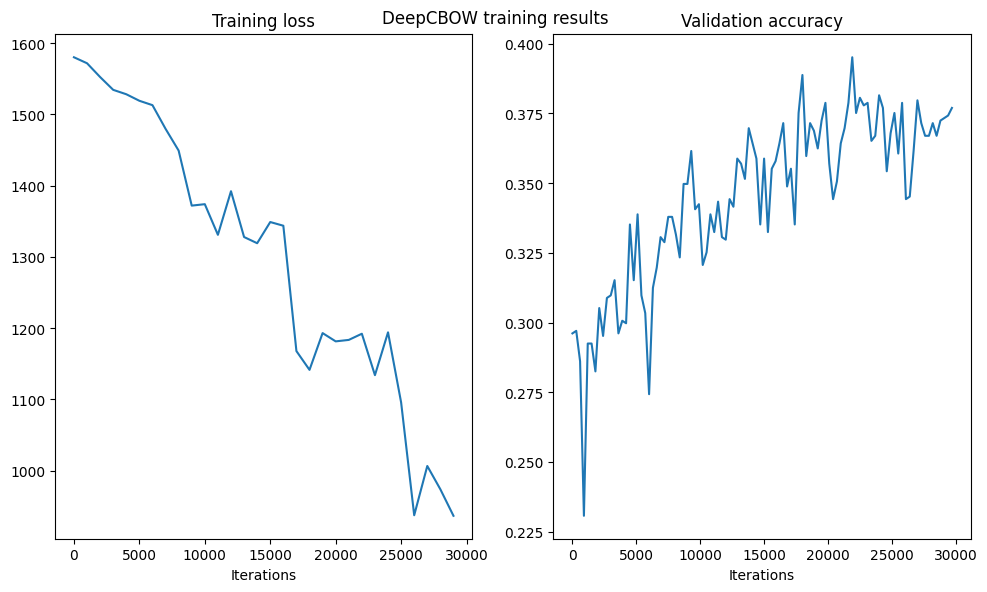

In [ ]:
# run training loop over multiple seeds
n_runs = 3
dcbow_model, dcbow_losses, dcbow_accuracies, dcbow_test_accs, dcbow_test_accs_short, dcbow_test_accs_long = train_loop(
    lambda: DeepCBOW(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=30000, num_seeds=n_runs, patience=50000, verbose=False)

print(f'Average test accuracy of DeepCBOW across {n_runs} runs: {np.mean(dcbow_test_accs)*100:.2f} +- {np.std(dcbow_test_accs)*100:.2f} %')
print(f'Average test accuracy of DeepCBOW on short sentences across {n_runs} runs: {np.mean(dcbow_test_accs_short)*100:.2f} +- {np.std(dcbow_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of DeepCBOW on long sentences across {n_runs} runs: {np.mean(dcbow_test_accs_long)*100:.2f} +- {np.std(dcbow_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(dcbow_losses, dcbow_accuracies, 'DeepCBOW', save=True)

In [ ]:
# Using subtrees
dcbow_model_st = DeepCBOW(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(dcbow_model_st.parameters(), lr=0.0005)
_, _, test_acc_dcbow_st, test_acc_dcbow_st_short, test_acc_dcbow_st_long = train_model(dcbow_model_st, optimizer, num_iterations=30000, patience=50000, subtrees=True, verbose=False)
print(f'Test accuracy of DeepCBOW model with subtrees: {test_acc_dcbow_st*100:.2f}%')

Done training
best model iter 29400: train acc=0.5159, dev acc=0.5035, test acc=0.1910
Test accuracy of DeepCBOW model with subtrees: 19.10%


# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**. 
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014. 

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space. 

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove. 
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [ ]:
# This downloads the Glove 840B 300d embeddings.
# !wget -nc -P ./data/ https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt
# This downloads the word2vec 300D Google News vectors 
# !wget -nc -P ./data/ https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

At this point you have the pre-trained word embedding files, but what do they look like?

In [ ]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# with open(f'{DATA_DIR}/glove.840B.300d.sst.txt') as file:
# 	for i, line in enumerate(file):
# 		if i > 3:
# 			break
# 		print(line)

So on every line we first get a token and then 300 floats making up the components of the respective embedding

#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary. 
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training. 

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1, 
 - and then all words in the pre-trained embedding set.
 

After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```

Remember to add new embeddings for the `<unk>` and `<pad>` tokens, as they're not part of the word2vec/GloVe embeddings. These embeddings can be randomly initialized or 0-valued, think about what makes sense and see what the effects are.
 

In [ ]:
def vocab_from_embeddings_file(path):
    v = Vocabulary()
    vectors = []

    v.i2w.append('<unk>')
    v.w2i['<unk>'] = 0
    vectors.append(300 * [0])
    v.i2w.append('<pad>')
    v.w2i['<pad>'] = 1
    vectors.append(300 * [0])

    for i, embed in enumerate(filereader(path), 2):
        embed_split = embed.split()
        v.i2w.append(embed_split[0])
        v.w2i[embed_split[0]] = i
        vectors.append(embed_split[1:])

    vectors = np.stack(vectors, axis=0).astype(np.double)

    return v, vectors

v, vectors = vocab_from_embeddings_file(f'{DATA_DIR}/googlenews.word2vec.300d.txt')

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [ ]:
words_not_found = set()
vocab_set = set(v.i2w)

for dataset, dataset_name in zip([train_data, dev_data, test_data], ['training', 'dev', 'test']):
    vocab_dataset = {token for sentence in dataset for token in sentence.tokens}
    # intersection = vocab_set.intersection(vocab_dataset)
    tokens_missing = vocab_dataset - vocab_set
    words_not_found = words_not_found.union(tokens_missing)
    
    vocab_dataset_len = len(vocab_dataset)
    tokens_missing_len = len(tokens_missing)
    print(f'The {dataset_name} set has a vocab size of {vocab_dataset_len} of which {vocab_dataset_len - tokens_missing_len} tokens are also in v and {tokens_missing_len} are not.')

print(f'{len(words_not_found)} tokens in total are in either the training, dev, and test set but not in v.')

The training set has a vocab size of 18278 of which 16167 tokens are also in v and 2111 are not.
The dev set has a vocab size of 5374 of which 5010 tokens are also in v and 364 are not.
The test set has a vocab size of 8547 of which 7844 tokens are also in v and 703 are not.
2779 tokens in total are in either the training, dev, and test set but not in v.


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [ ]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
		super().__init__(
		vocab_size, embedding_dim, hidden_dim, output_dim, vocab)
  
def prep_ptdcbow_model(**kwargs):
	'''Create a Deep CBOW model with pre-trained embeddings'''
	ptdcbow_model = PTDeepCBOW(**kwargs)
	# copy pre-trained word vectors into embeddings table
	ptdcbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))
	# disable training the pre-trained embeddings
	ptdcbow_model.embed.weight.requires_grad = False
	return ptdcbow_model

# run training loop over multiple seeds
n_runs = 3
ptdcbow_model, ptdcbow_losses, ptdcbow_accuracies, ptdcbow_test_accs, ptdcbow_test_accs_short, ptdcbow_test_accs_long = train_loop(
	lambda: prep_ptdcbow_model(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v),
	lambda model: optim.Adam(model.parameters(), lr=0.0001),
	num_iterations=30000, num_seeds=n_runs, patience=5000, verbose=False)

print(f'Average test accuracy of PT-DeepCBOW across {n_runs} runs: {np.mean(ptdcbow_test_accs)*100:.2f} +- {np.std(ptdcbow_test_accs)*100:.2f} %')
print(f'Average test accuracy of PT-DeepCBOW on short sentences across {n_runs} runs: {np.mean(ptdcbow_test_accs_short)*100:.2f} +- {np.std(ptdcbow_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of PT-DeepCBOW on long sentences across {n_runs} runs: {np.mean(ptdcbow_test_accs_long)*100:.2f} +- {np.std(ptdcbow_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(ptdcbow_losses, ptdcbow_accuracies, 'PT-DeepCBOW', save=True)

In [ ]:
# Using subtrees
ptdcbow_model_st = PTDeepCBOW(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(ptdcbow_model_st.parameters(), lr=0.0001)
_, _, test_acc_ptdcbow_st, test_acc_ptdcbow_st_short, test_acc_ptdcbow_st_long = train_model(ptdcbow_model_st, optimizer, num_iterations=30000, patience=50000, subtrees=True, verbose=False)
print(f'Test accuracy of PT-DeepCBOW model with subtrees: {test_acc_ptdcbow_st*100:.2f}%')

Done training
best model iter 16500: train acc=0.5121, dev acc=0.4994, test acc=0.1765
Test accuracy of PT-DeepCBOW model with subtrees: 17.65%


**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

# LSTM
It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification. 
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, you can check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069 


#### Exercise: Finish the LSTM cell below. 
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [ ]:
class MyLSTMCell(nn.Module):
    """Custom LSTM cell class.
        Parameters:
            input_size: The number of expected features in the input x
            hidden_size: The number of features in the hidden state h
            bias: whether to use bias weights b_ih and b_hh. Default: True
            mode: operating mode. Options:
                'default': standard LSTM
                'nig': no input gate
                'nfg': no forget gate
                'nog': no output gate
                'niaf': no input activation
                'noaf' no output activation
                'cifg': coupled input & forget gates
                'np': no peephole
    """

    def __init__(self, input_size, hidden_size, bias=True, mode='default'):
        """Creates the weights for this LSTM"""
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.w_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        if mode in ['default', 'nig', 'nfg', 'nog', 'niaf', 'noaf', 'cifg', 'np']:
            self.mode = mode
        else: 
            raise ValueError('')
        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)  

    def forward(self, input_, hx, mask=None):
        """
        input is (batch, input_size)
        hx is ((batch, hidden_size), (batch, hidden_size))
        """
        prev_h, prev_c = hx
        gates = (input_ @ self.w_ih.t() + self.bias_ih + 
                 prev_h @ self.w_hh.t() + self.bias_hh)

        i, f, g, o = gates.chunk(4, 1)
        if self.mode == 'nig':
            i = torch.ones_like(i)
        elif self.mode == 'niaf':
            i = i
        else:
            i = torch.sigmoid(i)
        if self.mode == 'nfg':
            f = torch.zeros_like(f)
        elif self.mode == 'cifg':
            f = 1 - i
        else:
            f = torch.sigmoid(f)
        g = torch.tanh(g)
        if self.mode == 'nog':
            o = torch.ones_like(o)
        elif self.mode == 'noaf':
            o = o
        else:
            o = torch.sigmoid(o)

        c = f * prev_c + i * g
        h = o * torch.tanh(c)

        return h, c


#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$ 

with $h = $ `prev_h` and $x = $ `input_`.

and where: 

$W_h =  \begin{pmatrix}
W_{hi}\\ 
W_{hf}\\ 
W_{hg}\\ 
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\ 
b_{hf}\\ 
b_{hg}\\ 
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\ 
W_{if}\\ 
W_{ig}\\ 
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\ 
b_{if}\\ 
b_{ig}\\ 
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state. 
You will find that code below. Make sure that you understand it.

In [ ]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, mode='default'):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim, mode=mode)
    
    self.output_layer = nn.Sequential(     
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):
    
    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)
    
    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)
    
    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []   
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)
    
    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.
      
      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]
      
      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)
      
      outputs = outputs.contiguous()      
      outputs = outputs.masked_fill_(pad_positions, 0.)
        
      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]
    
    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*. 

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$, 

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**Let's train our LSTM!** Note that is will be a lot slower than previous models because we need to do many more computations per sentence.

#### Training

In [ ]:
def prep_lstm(**kwargs):
    lstm_model = LSTMClassifier(**kwargs)
    # copy pre-trained word vectors into embeddings table
    with torch.no_grad():
        lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        lstm_model.embed.weight.requires_grad = False
    # print(lstm_model)
    # print_parameters(lstm_model)
    lstm_model = lstm_model.to(device)
    
    return lstm_model

# run training loop over multiple seeds
n_runs = 3
lstm_model, lstm_losses, lstm_accuracies, lstm_test_accs, lstm_test_accs_short, lstm_test_accs_long = train_loop(
    lambda: prep_lstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=168, output_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=30000, num_seeds=n_runs, patience=5000, verbose=False)

print(f'Average test accuracy of LSTM across {n_runs} runs: {np.mean(lstm_test_accs)*100:.2f} +- {np.std(lstm_test_accs)*100:.2f} %')
print(f'Average test accuracy of LSTM on short sentences across {n_runs} runs: {np.mean(lstm_test_accs_short)*100:.2f} +- {np.std(lstm_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of LSTM on long sentences across {n_runs} runs: {np.mean(lstm_test_accs_long)*100:.2f} +- {np.std(lstm_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(lstm_losses, lstm_accuracies, 'LSTM', save=True)

In [ ]:
# Using subtrees
lstm_model_st = LSTMClassifier(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(lstm_model_st.parameters(), lr=0.0005)
_, _, test_acc_lstm_st, test_acc_lstm_st_short, test_acc_lstm_st_long = train_model(lstm_model_st, optimizer, num_iterations=10000, patience=2000, subtrees=True, verbose=False)
print(f'Test accuracy of LSTM model with subtrees: {test_acc_lstm_st*100:.2f}%')

**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [ ]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""
  
  if shuffle:
    # print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  
  batch = []
  
  # yield minibatches
  for example in data:
    batch.append(example)
    
    if len(batch) == batch_size:
      yield batch
      batch = []
      
  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [ ]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [ ]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])
  
  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]
  
  x = torch.LongTensor(x)
  x = x.to(device)
  
  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)
  
  return x, y

In [ ]:
# Let's test our new function.
# This should give us 3 examples.
# mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
# for ex in mb:
#   print(ex)
# We should find padding 1s at the end
# x, y = prepare_minibatch(mb, v)
# print("x", x)
# print("y", y)

#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [ ]:
def evaluate(model, data, 
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)
      
    predictions = logits.argmax(dim=-1).view(-1)
    
    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

Training model with seed 0
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell()
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.w_ih                 [672, 300]   requires_grad=True
rnn.w_hh                 [672, 168]   requires_grad=True
rnn.bias_ih              [672]        requires_grad=True
rnn.bias_hh              [672]        requires_grad=True
output_layer.1.weight    [5, 168]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

Total number of parameters: 5993285

Done training
Early stopping
best model iter 3600: train acc=0.5782, dev acc=0.4623, test acc=0.4584
Test accuracy for seed 0: 0.4583710407239819
Training model with seed 1
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell()
  (output_layer): Sequential(
    (0): Dropout(p=0.5, i

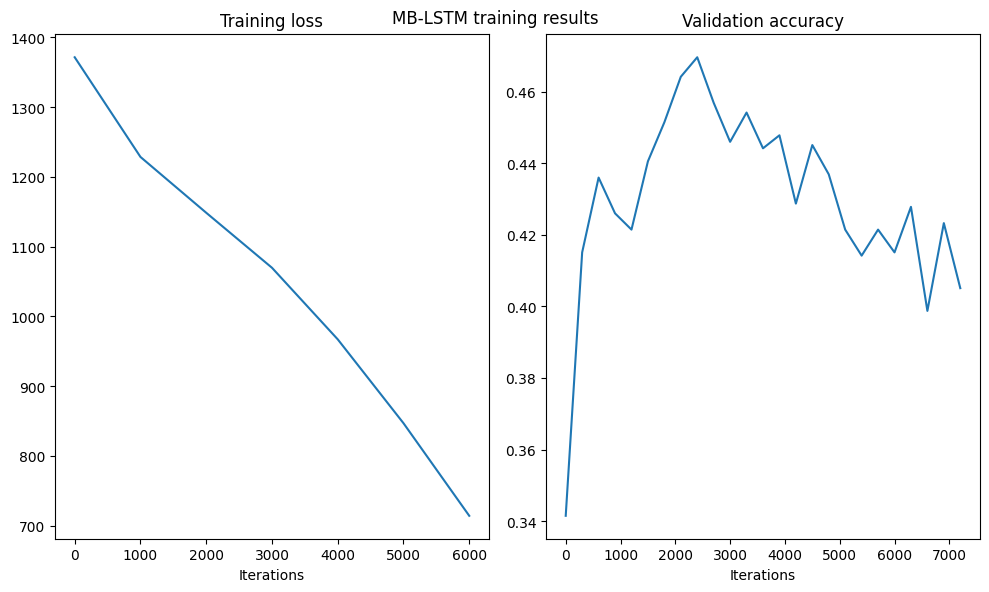

In [ ]:
# run training loop over multiple seeds
n_runs = 3
mblstm_model, mblstm_losses, mblstm_accuracies, mblstm_test_accs, mblstm_test_accs_short, mblstm_test_accs_long = train_loop(
    lambda: prep_lstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=168, output_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=30000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate, num_seeds=n_runs, patience=5000, verbose=False)

print(f'Average test accuracy of MB-LSTM across {n_runs} runs: {np.mean(mblstm_test_accs)*100:.2f} +- {np.std(mblstm_test_accs)*100:.2f} %')
print(f'Average test accuracy of MB-LSTM on short sentences across {n_runs} runs: {np.mean(mblstm_test_accs_short)*100:.2f} +- {np.std(mblstm_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of MB-LSTM on long sentences across {n_runs} runs: {np.mean(mblstm_test_accs_long)*100:.2f} +- {np.std(mblstm_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(mblstm_losses, mblstm_accuracies, 'MB-LSTM', save=True)

In [ ]:
# Using subtrees
mblstm_model_st = prep_lstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=168, output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(mblstm_model_st.parameters(), lr=0.0005)
_, _, test_acc_mblstm_st, test_acc_mblstm_st_short, test_acc_mblstm_st_long = train_model(mblstm_model_st, optimizer, num_iterations=10000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate, patience=3000,subtrees=True, verbose=False)
print(f'Test accuracy of LSTM model with subtrees: {test_acc_mblstm_st*100:.2f}%')

Done training
Early stopping
best model iter 3000: train acc=0.5185, dev acc=0.3043, test acc=0.2615
Test accuracy of LSTM model with subtrees: 26.15%


## Comparing LSTM models
We compare variants of the LSTM, namely:
- vanilla LSTM 
- No input gate (NIG) LSTM
- No output gate (NOG) LSTM
- No forget gate (NFG) LSTM
- No input activation (NIAF) LSTM
- No output activation (NOAF) LSTM
- No peephole (NP) LSTM
- Coupled input and forget (CIFG) LSTM

In [ ]:
# Run the LSTM model with different modes
lstm_modes = ['default', 'nig', 'nfg', 'nog', 'niaf', 'noaf', 'np', 'cifg']
lstm_train_losses, lstm_val_accs, lstm_test_accs = {}, {}, {}
# we do 1 run per model because it takes a long time, and the variance between different seeds is low. We use the same seed for each model
seed=RANDOM_SEED 
for mode in lstm_modes:
    lstm_model_var = prep_lstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=168, output_dim=len(t2i), vocab=v, mode=mode)
    optimizer = optim.Adam(lstm_model_var.parameters(), lr=0.0005)
    set_seed(seed)
    train_losses_lstm_var, val_accs_lstm_var, test_acc_lstm_var, _, _ = train_model(lstm_model_var, optimizer, num_iterations=10000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate, patience=3000, rand_seed=seed, suffix='_'+mode, verbose=False)
    lstm_train_losses[mode] = train_losses_lstm_var
    lstm_val_accs[mode] = val_accs_lstm_var
    lstm_test_accs[mode] = test_acc_lstm_var
    print(f'Test accuracy of {mode.upper()} LSTM model: {test_acc_lstm_var*100:.2f}%')

Done training
Early stopping
best model iter 2400: train acc=0.5199, dev acc=0.4569, test acc=0.4701
Test accuracy of default LSTM model: 47.01%
Done training
Early stopping
best model iter 1500: train acc=0.4889, dev acc=0.4496, test acc=0.4534
Test accuracy of nig LSTM model: 45.34%
Done training
Early stopping
best model iter 2100: train acc=0.4690, dev acc=0.4233, test acc=0.4249
Test accuracy of nfg LSTM model: 42.49%
Done training
Early stopping
best model iter 1800: train acc=0.5165, dev acc=0.4596, test acc=0.4615
Test accuracy of nog LSTM model: 46.15%
Done training
Early stopping
best model iter 3000: train acc=0.7068, dev acc=0.4759, test acc=0.4611
Test accuracy of niaf LSTM model: 46.11%
Done training
Early stopping
best model iter 900: train acc=0.4532, dev acc=0.4450, test acc=0.4335
Test accuracy of noaf LSTM model: 43.35%
Done training
Early stopping
best model iter 3300: train acc=0.5680, dev acc=0.4541, test acc=0.4520
Test accuracy of np LSTM model: 45.20%
Done trai

In [ ]:
# print the test accuracies of the different LSTM models
for mode in lstm_modes:
    print(f'Test accuracy of {mode.upper()} LSTM model: {lstm_test_accs[mode]*100:.2f}%')

Test accuracy of DEFAULT LSTM model: 47.01%
Test accuracy of NIG LSTM model: 45.34%
Test accuracy of NFG LSTM model: 42.49%
Test accuracy of NOG LSTM model: 46.15%
Test accuracy of NIAF LSTM model: 46.11%
Test accuracy of NOAF LSTM model: 43.35%
Test accuracy of NP LSTM model: 45.20%
Test accuracy of CIFG LSTM model: 46.52%


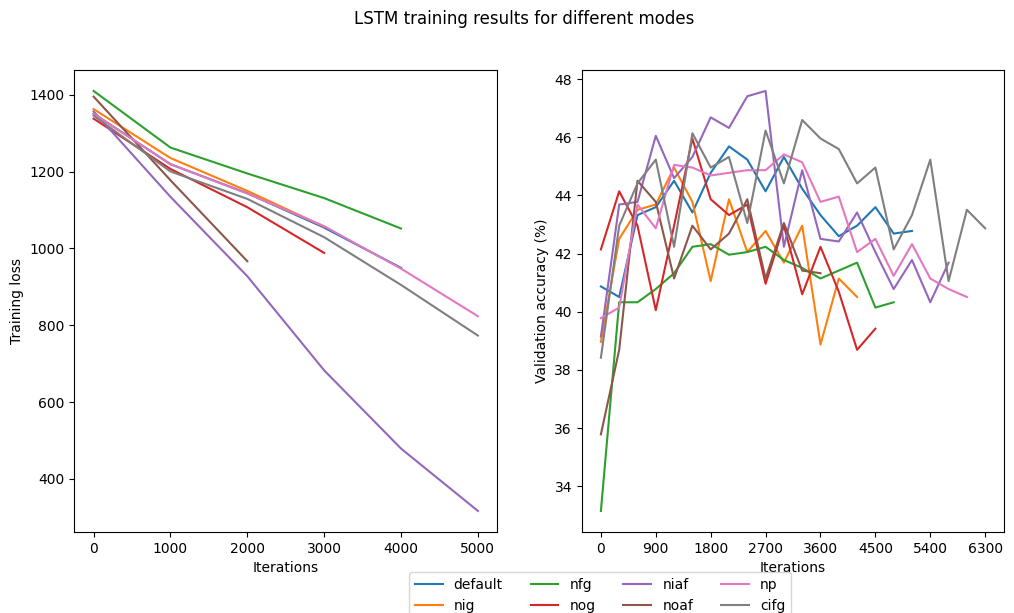

In [ ]:
# plot the training loss and validation accuracy for each lstm model
print_every, eval_every = 1000, 300
max_len_losses_lstm_var = max([len(lstm_train_losses[mode]) for mode in lstm_modes])
max_len_accs_lstm_var = max([len(lstm_val_accs[mode]) for mode in lstm_modes])
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for mode in lstm_modes:
    axs[0].plot(lstm_train_losses[mode], label=mode)
    axs[0].set_xticks([i for i in range(max_len_losses_lstm_var)])
    axs[0].set_xticklabels([i*print_every for i in range(max_len_losses_lstm_var)])
    axs[0].set_ylabel('Training loss')
    axs[0].set_xlabel('Iterations')
    axs[1].plot([acc*100 for acc in lstm_val_accs[mode]])
    axs[1].set_xticks([i for i in range(max_len_accs_lstm_var) if i%3 == 0])
    axs[1].set_xticklabels([i*eval_every for i in range(max_len_accs_lstm_var) if i%3 == 0])
    axs[1].set_ylabel('Validation accuracy (%)')
    axs[1].set_xlabel('Iterations')   
fig.suptitle(f'LSTM training results for different modes')
fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
# fig.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/lstm_modes_loss_acc.png')

# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data. 
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [ ]:
ex = next(examplereader(f'{DATA_DIR}/trees/dev.txt'))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-59-7ea4c7d56a08>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a 
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a 
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 
```

Et voilà. We just obtained the transition sequence!

In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise 
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [ ]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True, mode='nary'):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.mode = mode

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)  

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))    
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)
    
    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation
    if self.mode == 'nary':
        i = torch.sigmoid(i)
        f_l = torch.sigmoid(f_l)
        f_r = torch.sigmoid(f_r)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c = (f_l * prev_c_l) + (f_r * prev_c_r) + (i * g)
        h = o * torch.tanh(c)
    
    elif self.mode == 'child-sum':
        child_h_sum = torch.sum((prev_h_l + prev_h_r), dim=0, keepdim=True)
        f = torch.sigmoid(f_l + f_r)
        i = torch.sigmoid(i) 
        g = torch.tanh(g)  
        o = torch.sigmoid(o)
        c = i * g + f * child_h_sum
        h = o * torch.tanh(c)
        
    else:
        raise ValueError(f'Mode must be either "nary" or "child-sum", not {self.mode}')
    
    return h, c
  
  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent. 


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier. 

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} = 
\begin{pmatrix}
0 & 0\\ 
0 & 0\\ 
1 & 1\\ 
0 & 0\\ 
0 & 0\\ 
0 & 1\\ 
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs. 

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2. 

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching. 

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves. 

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [ ]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but 
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing. 
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [ ]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True, mode='nary'):
    """Creates the weights for this LSTM. The mode can be either 'nary' or 'child-sum'.
    """
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size, bias, mode) 

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)
    
    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h
    
    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [ ]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, mode='nary'):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim,mode=mode)
    self.output_layer = nn.Sequential(     
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):
    
    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)
    
    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [ ]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.  
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])
    
  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]
  
  x = torch.LongTensor(x)
  x = x.to(device)
  
  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)
  
  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major
  
  return (x, transitions), y

In [ ]:
# string = next(filereader(f'{DATA_DIR}/trees/dev.txt'))
# tree = Tree.fromstring(string)
# print("Subtrees:")
# for subtree in get_subtrees(tree):
#   print(TreePrettyPrinter(subtree))

## Training

Training model with seed 0
Done training
Early stopping
best model iter 1200: train acc=0.4865, dev acc=0.4587, test acc=0.4620
Test accuracy for seed 0: 0.46199095022624437
Training model with seed 1
Done training
Early stopping
best model iter 2100: train acc=0.5275, dev acc=0.4587, test acc=0.4729
Test accuracy for seed 1: 0.47285067873303166
Training model with seed 2
Done training
Early stopping
best model iter 1200: train acc=0.4838, dev acc=0.4469, test acc=0.4602
Test accuracy for seed 2: 0.4601809954751131
Average test accuracy of MB-LSTM across 3 runs: 46.50 +- 0.56 %
Average test accuracy of Tree-LSTM on short sentences across 3 runs: 48.70 +- 0.63 %
Average test accuracy of Tree-LSTM on long sentences across 3 runs: 44.29 +- 0.61 %


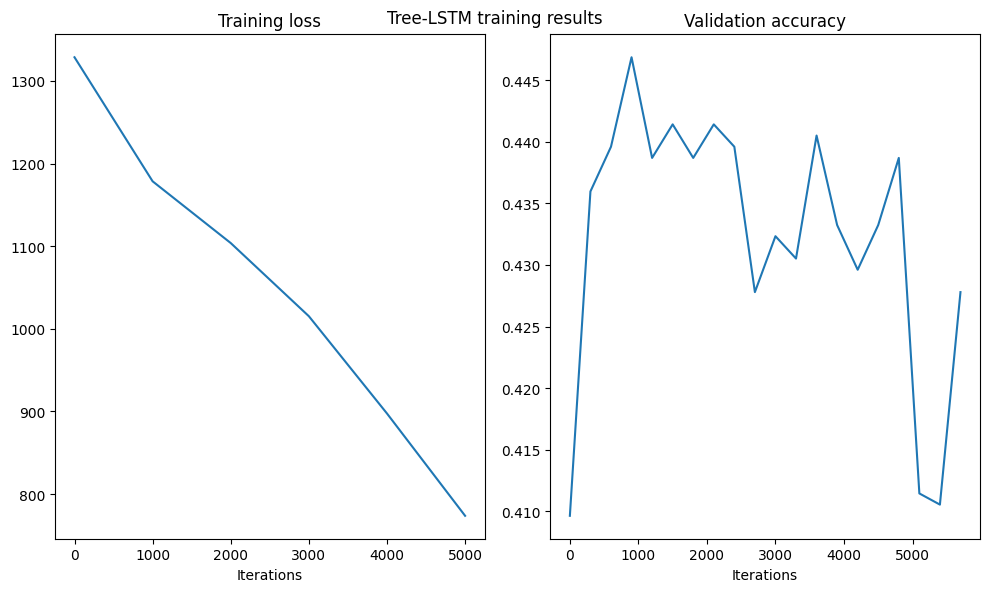

In [ ]:
# Now let's train the Tree LSTM!
def prep_treelstm(**kwargs):
    tlstm_model = TreeLSTMClassifier(**kwargs)
    with torch.no_grad():
        tlstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tlstm_model.embed.weight.requires_grad = False
    # print(tlstm_model)
    # print_parameters(tlstm_model)
    tlstm_model.to(device)

    return tlstm_model
  
# run training loop over multiple seeds
n_runs = 3
tlstm_model, tlstm_losses, tlstm_accuracies, tlstm_test_accs, tlstm_test_accs_short, tlstm_test_accs_long = train_loop(
    lambda: prep_treelstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=150, output_dim=len(t2i), vocab=v),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=30000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch,eval_fn=evaluate, num_seeds=n_runs, patience=5000, verbose=False)

print(f'Average test accuracy of MB-LSTM across {n_runs} runs: {np.mean(tlstm_test_accs)*100:.2f} +- {np.std(tlstm_test_accs)*100:.2f} %')
print(f'Average test accuracy of Tree-LSTM on short sentences across {n_runs} runs: {np.mean(tlstm_test_accs_short)*100:.2f} +- {np.std(tlstm_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of Tree-LSTM on long sentences across {n_runs} runs: {np.mean(tlstm_test_accs_long)*100:.2f} +- {np.std(tlstm_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(tlstm_losses, tlstm_accuracies, 'Tree-LSTM', save=True)

In [ ]:
# Using subtrees
tlstm_model_st = prep_treelstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=150, output_dim=len(t2i), vocab=v)
optimizer = optim.Adam(tlstm_model_st.parameters(), lr=0.0005)
_, _, test_acc_tlstm_st, test_acc_tlstm_st_short, test_acc_tlstm_st_long = train_model(tlstm_model_st, optimizer, num_iterations=10000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate, patience=3000, subtrees=True, verbose=False)
print(f'Test accuracy of T-LSTM model with subtrees: {test_acc_tlstm_st*100:.2f}%')

Done training
Early stopping
best model iter 3900: train acc=0.5484, dev acc=0.4342, test acc=0.4344
Test accuracy of T-LSTM model with subtrees: 43.44%


### Child-sum Tree-LSTM

Average test accuracy of Child-sum Tree-LSTM across 3 runs: 46.14 +- 0.17 %
Average test accuracy of Child-sum Tree-LSTM on short sentences across 3 runs: 48.01 +- 0.45 %
Average test accuracy of Child-sum Tree-LSTM on long sentences across 3 runs: 44.96 +- 0.48 %


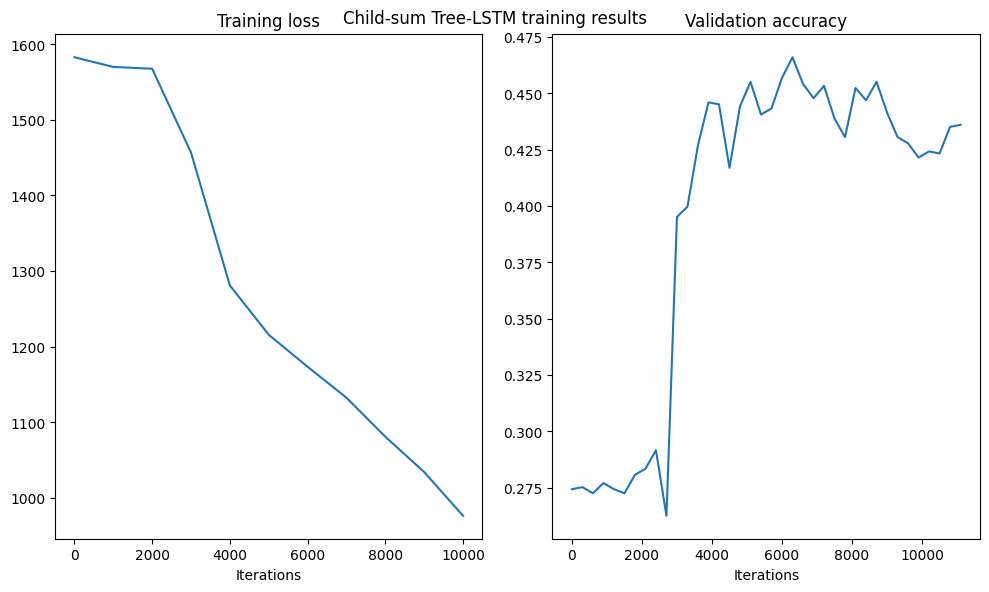

In [ ]:
# run training loop over multiple seeds
n_runs = 3
tlstm_cs_model, tlstm_cs_losses, tlstm_cs_accuracies, tlstm_cs_test_accs, tlstm_cs_test_accs_short, tlstm_cs_test_accs_long = train_loop(
    lambda: prep_treelstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=150, output_dim=len(t2i), vocab=v, mode='child-sum'),
    lambda model: optim.Adam(model.parameters(), lr=0.0005),
    num_iterations=30000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch,eval_fn=evaluate, num_seeds=n_runs, patience=5000, suffix = '_cs', verbose=False)

print(f'Average test accuracy of Child-sum Tree-LSTM across {n_runs} runs: {np.mean(tlstm_cs_test_accs)*100:.2f} +- {np.std(tlstm_cs_test_accs)*100:.2f} %')
print(f'Average test accuracy of Child-sum Tree-LSTM on short sentences across {n_runs} runs: {np.mean(tlstm_cs_test_accs_short)*100:.2f} +- {np.std(tlstm_cs_test_accs_short)*100:.2f} %')
print(f'Average test accuracy of Child-sum Tree-LSTM on long sentences across {n_runs} runs: {np.mean(tlstm_cs_test_accs_long)*100:.2f} +- {np.std(tlstm_cs_test_accs_long)*100:.2f} %')
# Plot the training loss and validation accuracy
plot_loss_acc(tlstm_cs_losses, tlstm_cs_accuracies, 'Child-sum Tree-LSTM', save=True)

In [ ]:
# Using subtrees
tlstm_cs_model_st = prep_treelstm(vocab_size=len(v.w2i), embedding_dim=300, hidden_dim=150, output_dim=len(t2i), vocab=v, mode='child-sum')
optimizer = optim.Adam(tlstm_cs_model_st.parameters(), lr=0.0005)
_, _, test_acc_tlstm_cs_st, test_acc_tlstm_cs_st_short, test_acc_tlstm_cs_st_long = train_model(tlstm_cs_model_st, optimizer, num_iterations=10000, batch_size=25, batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch,eval_fn=evaluate, patience=3000, suffix='_cs', subtrees=True, verbose=False)
print(f'Test accuracy of Child-sum Tree-LSTM model with subtrees: {test_acc_tlstm_cs_st*100:.2f}%')

Done training
Early stopping
best model iter 6600: train acc=0.5475, dev acc=0.4460, test acc=0.4281
Test accuracy of Child-sum Tree-LSTM model with subtrees: 42.81%


## Compare results of all models

In [ ]:
# # Plot results (train loss, val loss) for all models
# # load results
# model_names = ['BOW', 'CBOW', 'DeepCBOW', 'PTDeepCBOW', 'LSTMClassifier', 'LSTMClassifier', 'TreeLSTMClassifier', 'TreeLSTMClassifier_cs']
# batch_sizes = [1, 1, 1, 1, 1, 25, 25, 25]
# num_iters = [50000, 50000, 30000, 30000, 30000, 30000, 30000, 30000]
# lr = 0.0005
# results_dict = {}
# for model_name, batch_size, iters in zip(model_names, batch_sizes, num_iters):
#     ckpt_path = f'{MODEL_DIR}/{model_name}_st=False_lr={lr}_bs={batch_size}_iter={iters}.pt'
#     ckpt = torch.load(ckpt_path)
#     print(model_name)
#     print(ckpt.keys())
#     results_dict[model_name] = {'train_losses': ckpt['train_losses'], 'val_accs': ckpt['val_accs']}

# # plot results
# print_every, eval_every = 1000, 300
# max_len_losses = max([len (results_dict[model_name]['train_losses']) for model_name in model_names])
# max_len_accs = max([len(results_dict[model_name]['val_accs']) for model_name in model_names])
# fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# for model_name, results in results_dict.items():
#     axs[0].plot(results['train_losses'], label=model_name)
#     axs[0].set_xticks(range(0, max_len_losses, eval_every))
#     axs[0].set_xticks([i for i in range(max_len_losses)])
#     axs[0].set_xticklabels([i*print_every for i in range(max_len_losses)])
#     axs[0].set_xlabel('Iterations')
#     axs[0].set_ylabel('Train Loss')
#     axs[1].plot(results['val_accs']*100, label=model_name)
#     axs[1].set_xticks([i for i in range(max_len_accs)])
#     axs[1].set_xticklabels([i*eval_every for i in range(max_len_accs)])
#     axs[1].set_xlabel('Iterations')
#     axs[1].set_ylabel('Validation Accuracy (%)')
# # set legend at bottom center of figure
# fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
# fig.tight_layout()
# fig.savefig('all_models_loss_acc.png')

# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring. 
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

**To be able to obtain a full grade (10), you should conduct further investigations.** For example, you can also investigate one the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM? 
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or... your own research question!

These examples should give you an idea of the expected scope of your further investigations.

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed. 
More precisely, you should run each model with 3 different seeds, and for each of these 3 runs, evaluate the best model (according to the validation) on the test dataset. The validation dataset is used for finding the best model over iterations, but the accuracy you report should be on the test dataset.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2020 template which you can download from or edit directly on [Overleaf](https://www.overleaf.com/latex/templates/instructions-for-acl-2018-proceedings/xzmhqgnmkppc). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `\aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project. 

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Present your research questions
    - Motivate the importance of the questions
    - Present and explain your expectations
    - Make clear whether the research questions are addressed or not addressed in the literature
    - Describe the approach you use to answer the research questions
    - Summarise your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree-LSTM) and intuitions behind them. Be accurate and concise.
    - How does each technique work? (Don't just copy the formulas)
    - What is the relation between the techniques?
3. Models (~1/2 page) - Describe the architecture of the final models.
    - How do you use LSTM or Tree-LSTM for the sentiment classification task? 
    - What layers do you have, how do you do classification? 
    - What is your loss function?
    - Etc.
4. Experiments (~1/2 page) - Describe your experimental setup. This section should allow someone else to reproduce your experiments. Describe how you evaluate the models.
    - Task and the data
    - Training (model, data, parameters and hyper parameters, training algorithms, supervision signals, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Present the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Use figures and tables to highlight interesting patterns
    - What are the factors that make model A better than model B in task C? Investigate to prove their effect!
6. Conclusion (~1/4 page). Present the conclusions that can be drawn from your experiments.
    - What have you learned from you experiments?
    - How do your findings relate to what is already known in the literature?
    - Were the results as expected? Any surprising results? Why?
    - Based on what you learned, what would you suggest doing next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation).
- Define technical terminology you need.
- Avoid colloquial language – everything can be said in a scientific-sounding way.
- Avoid lengthy sentences, stay to the point.
- Do not spend space on "obvious" things.
- Do not go over the page limit. (We will deduct points for that.)
- The page limit is 4 pages excluding references and appendix. This is a strict limit; points will be deducted for longer reports. 
- There is no strict limit to references and appendix. However, the report needs to remain fully self-contained: the appendix should only include content that is not necessary to understand your work. For example, preprocessing decisions, model parameters, pseudocode, sample system inputs/outputs, and other details that are necessary for the exact replication of your work can be put into the appendix. 


An ideal report:
- Precise, scientific-sounding, technical, to the point 
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)
